#  Premier pas vers lindustrialisation avec les pipelines scikit




<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=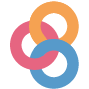)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb)

# Pourquoi utiliser les pipelines ?

Les chapitres précédents ont permis de montrer des bouts de code 
épars pour entraîner des modèles ou faire du _preprocessing_.
Cette démarche est intéressante pour tâtonner mais risque d'être coûteuse
ultérieurement s'il est nécessaire d'ajouter une étape de preprocessing 
ou de changer d'algorithme.

Heureusement, `scikit` propose un excellent outil pour proposer un cadre
général pour créer une chaîne de production *machine learning*. Il
s'agit des
[_pipelines_](https://scikit-learn.org/stable/modules/compose.html). 
Ils présentent de nombreux intérêts, parmi lesquels:

* Ils sont très __pratiques__ et __lisibles__. On rentre des données en entrée, on n'appelle qu'une seule fois les méthodes `fit` et `predict` ce qui permet de s'assurer une gestion cohérente des transformations de variables, par exemple après l'appel d'un `StandardScaler`
* La __modularité__ rend aisée la mise à jour d'un pipeline et renforce la capacité à le réutiliser
* Ils permettent de facilement chercher les hyperparamètres d'un modèle. Sans *pipeline*, écrire un code qui fait du *tuning* d'hyperparamètres peut être pénible. Avec les *pipelines*, c'est une ligne de code. 
* La __sécurité__ d'être certain que les étapes de preprocessing sont bien appliquées aux jeux de données désirés avant l'estimation. 

Un des intérêts des *pipelines* scikit est qu'ils fonctionnent aussi avec
des méthodes qui ne sont pas issues de `scikit`. Il est très 
facile d'introduire un modèle de réseau de neurone `Keras` dans
un pipeline `scikit`. Pour introduire un modèle économétrique `statsmodels`
c'est un peu plus coûteux mais nous allons proposer des exemples
qui peuvent servir de modèle et qui montrent que c'est faisable 
sans trop de difficulté.

# Comment créer un *pipeline*

Un *pipeline* est un enchaînement d'opérations qu'on code en enchainant
des pairs *(clé, valeur)*:

* la clé est le nom du pipeline, cela peut être utile lorsqu'on va
représenter le *pipeline* sous forme de diagramme acyclique (visualisation DAG)
ou qu'on veut afficher des informations sur une étape
* la valeur représente la transformation à mettre en oeuvre dans le *pipeline*
(c'est-à-dire, à l'exception de la dernière étape, 
mettre en oeuvre une méthode `transform` et éventuellement une
transformation inverse).



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)

Il est pratique de visualiser un *pipeline* sous forme de DAG.
Pour cela, dans un notebook, on utilise la configuration
suivante:


In [ ]:
from sklearn import set_config
set_config(display='diagram') 

In [ ]:
pipe

```
## Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])
```


```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'estimator_html_repr' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```
